Demo visibility xarray format

In [1]:
import astropy.units as u
import numpy
from astropy.coordinates import SkyCoord

from rascil.data_models import PolarisationFrame
from rascil.processing_components.simulation import create_named_configuration
from rascil.processing_components.visibility.base import create_blockvisibility

Set up a test visibility set

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE', rmax=1000)
times = (numpy.pi / 43200.0) * numpy.arange(-4 * 3600, +4 * 3600.0, 1800)
frequency = numpy.linspace(1.0e8, 1.1e8, 5)
channel_bandwidth = numpy.array([1e7, 1e7, 1e7, 1e7, 1e7])
# Define the component and give it some spectral behaviour
f = numpy.array([100.0, 20.0, -10.0, 1.0])
flux = numpy.array([f, 0.8 * f, 0.6 * f, 0.4 * f, 0.2 * f])
phasecentre = SkyCoord(ra=+180.0 * u.deg, dec=-35.0 * u.deg, frame='icrs',
                       equinox='J2000')
xvis = create_blockvisibility(lowcore, times, frequency,
                                  channel_bandwidth=channel_bandwidth,
                                  phasecentre=phasecentre,
                                  integration_time=1800.0,
                                  polarisation_frame=PolarisationFrame("linear"),
                                  weight=1.0)

In [3]:
assert xvis.vis.shape == (16, 13861, 5, 4), xvis.vis.shape
assert xvis.data["uvw"].shape == (16, 13861, 3), xvis["uvw"].shape
assert xvis.data["uvw_lambda"].shape == (16, 13861, 5, 3), xvis.data["uvw_lambda"].shape

Initial xvis

In [4]:
print(xvis)

BlockVisibility:
	Source unknown
	Phasecentre: <SkyCoord (ICRS): (ra, dec) in deg
    (180., -35.)>
	Polarisation Frame: linear
	Configuration: LOWBD2-CORE
	Metadata: None
	xarray.Dataset: <xarray.Dataset>
Dimensions:            (baseline: 13861, frequency: 5, polarisation: 4, time: 16, uvw_index: 3)
Coordinates:
  * time               (time) float64 5.085e+09 5.085e+09 ... 5.085e+09
  * baseline           (baseline) MultiIndex
  - antenna1           (baseline) int64 0 0 0 0 0 0 ... 163 163 163 164 164 165
  - antenna2           (baseline) int64 0 1 2 3 4 5 ... 163 164 165 164 165 165
  * frequency          (frequency) float64 1e+08 1.025e+08 ... 1.075e+08 1.1e+08
  * polarisation       (polarisation) <U2 'XX' 'XY' 'YX' 'YY'
  * uvw_index          (uvw_index) <U1 'u' 'v' 'w'
Data variables:
    integration_time   (time) float64 1.795e+03 1.795e+03 ... 1.795e+03
    datetime           (time) datetime64[ns] 2020-01-01T17:30:36.783709447 .....
    vis                (time, baseline, frequ

Selection of the Dataset by polarisation

In [5]:
print(xvis.data.sel({"polarisation": ["XY", "YX"]}))


<xarray.Dataset>
Dimensions:            (baseline: 13861, frequency: 5, polarisation: 2, time: 16, uvw_index: 3)
Coordinates:
  * time               (time) float64 5.085e+09 5.085e+09 ... 5.085e+09
  * baseline           (baseline) MultiIndex
  - antenna1           (baseline) int64 0 0 0 0 0 0 ... 163 163 163 164 164 165
  - antenna2           (baseline) int64 0 1 2 3 4 5 ... 163 164 165 164 165 165
  * frequency          (frequency) float64 1e+08 1.025e+08 ... 1.075e+08 1.1e+08
  * polarisation       (polarisation) <U2 'XY' 'YX'
  * uvw_index          (uvw_index) <U1 'u' 'v' 'w'
Data variables:
    integration_time   (time) float64 1.795e+03 1.795e+03 ... 1.795e+03
    datetime           (time) datetime64[ns] 2020-01-01T17:30:36.783709447 .....
    vis                (time, baseline, frequency, polarisation) complex128 0...
    weight             (time, baseline, frequency, polarisation) float64 0.0 ...
    imaging_weight     (time, baseline, frequency, polarisation) float64 0.0 ...
 

Selection of the Dataset by frequency

In [6]:
print(xvis.data.sel({"frequency": [1.0e8, 1.1e8]}))


<xarray.Dataset>
Dimensions:            (baseline: 13861, frequency: 2, polarisation: 4, time: 16, uvw_index: 3)
Coordinates:
  * time               (time) float64 5.085e+09 5.085e+09 ... 5.085e+09
  * baseline           (baseline) MultiIndex
  - antenna1           (baseline) int64 0 0 0 0 0 0 ... 163 163 163 164 164 165
  - antenna2           (baseline) int64 0 1 2 3 4 5 ... 163 164 165 164 165 165
  * frequency          (frequency) float64 1e+08 1.1e+08
  * polarisation       (polarisation) <U2 'XX' 'XY' 'YX' 'YY'
  * uvw_index          (uvw_index) <U1 'u' 'v' 'w'
Data variables:
    integration_time   (time) float64 1.795e+03 1.795e+03 ... 1.795e+03
    datetime           (time) datetime64[ns] 2020-01-01T17:30:36.783709447 .....
    vis                (time, baseline, frequency, polarisation) complex128 0...
    weight             (time, baseline, frequency, polarisation) float64 0.0 ...
    imaging_weight     (time, baseline, frequency, polarisation) float64 0.0 ...
    flags      

sel antenna1 yields smaller XVisibility

In [7]:
print(xvis.data.sel(indexers={"antenna1":10}, drop=False))

<xarray.Dataset>
Dimensions:            (antenna2: 156, frequency: 5, polarisation: 4, time: 16, uvw_index: 3)
Coordinates:
  * time               (time) float64 5.085e+09 5.085e+09 ... 5.085e+09
  * antenna2           (antenna2) int64 10 11 12 13 14 ... 161 162 163 164 165
  * frequency          (frequency) float64 1e+08 1.025e+08 ... 1.075e+08 1.1e+08
  * polarisation       (polarisation) <U2 'XX' 'XY' 'YX' 'YY'
  * uvw_index          (uvw_index) <U1 'u' 'v' 'w'
Data variables:
    integration_time   (time) float64 1.795e+03 1.795e+03 ... 1.795e+03
    datetime           (time) datetime64[ns] 2020-01-01T17:30:36.783709447 .....
    vis                (time, antenna2, frequency, polarisation) complex128 0...
    weight             (time, antenna2, frequency, polarisation) float64 0.0 ...
    imaging_weight     (time, antenna2, frequency, polarisation) float64 0.0 ...
    flags              (time, antenna2, frequency, polarisation) int64 0 0 ... 0
    uvw                (time, antenna2

where antenna1 yields masked arrays

In [8]:
print(xvis.data.where(xvis.data["antenna1"] == 10))

<xarray.Dataset>
Dimensions:            (baseline: 13861, frequency: 5, polarisation: 4, time: 16, uvw_index: 3)
Coordinates:
  * time               (time) float64 5.085e+09 5.085e+09 ... 5.085e+09
  * baseline           (baseline) MultiIndex
  - antenna1           (baseline) int64 0 0 0 0 0 0 ... 163 163 163 164 164 165
  - antenna2           (baseline) int64 0 1 2 3 4 5 ... 163 164 165 164 165 165
  * frequency          (frequency) float64 1e+08 1.025e+08 ... 1.075e+08 1.1e+08
  * polarisation       (polarisation) <U2 'XX' 'XY' 'YX' 'YY'
  * uvw_index          (uvw_index) <U1 'u' 'v' 'w'
Data variables:
    integration_time   (time, baseline) float64 nan nan nan nan ... nan nan nan
    datetime           (time, baseline) datetime64[ns] NaT NaT NaT ... NaT NaT
    vis                (time, baseline, frequency, polarisation) complex128 (...
    weight             (time, baseline, frequency, polarisation) float64 nan ...
    imaging_weight     (time, baseline, frequency, polarisation) f

By uvdist yields masked arrays

In [9]:
print(xvis.data.where(xvis.uvdist < 40.0))

<xarray.Dataset>
Dimensions:            (baseline: 13861, frequency: 5, polarisation: 4, time: 16, uvw_index: 3)
Coordinates:
  * time               (time) float64 5.085e+09 5.085e+09 ... 5.085e+09
  * baseline           (baseline) MultiIndex
  - antenna1           (baseline) int64 0 0 0 0 0 0 ... 163 163 163 164 164 165
  - antenna2           (baseline) int64 0 1 2 3 4 5 ... 163 164 165 164 165 165
  * frequency          (frequency) float64 1e+08 1.025e+08 ... 1.075e+08 1.1e+08
  * polarisation       (polarisation) <U2 'XX' 'XY' 'YX' 'YY'
  * uvw_index          (uvw_index) <U1 'u' 'v' 'w'
Data variables:
    integration_time   (time, baseline) float64 1.795e+03 nan ... nan 1.795e+03
    datetime           (time, baseline) datetime64[ns] 2020-01-01T17:30:36.78...
    vis                (time, baseline, frequency, polarisation) complex128 0...
    weight             (time, baseline, frequency, polarisation) float64 0.0 ...
    imaging_weight     (time, baseline, frequency, polarisation)

By time

In [10]:
print(xvis.data.where(xvis.data.datetime > numpy.datetime64("2020-01-01T23:00:00")))

<xarray.Dataset>
Dimensions:            (baseline: 13861, frequency: 5, polarisation: 4, time: 16, uvw_index: 3)
Coordinates:
  * time               (time) float64 5.085e+09 5.085e+09 ... 5.085e+09
  * baseline           (baseline) MultiIndex
  - antenna1           (baseline) int64 0 0 0 0 0 0 ... 163 163 163 164 164 165
  - antenna2           (baseline) int64 0 1 2 3 4 5 ... 163 164 165 164 165 165
  * frequency          (frequency) float64 1e+08 1.025e+08 ... 1.075e+08 1.1e+08
  * polarisation       (polarisation) <U2 'XX' 'XY' 'YX' 'YY'
  * uvw_index          (uvw_index) <U1 'u' 'v' 'w'
Data variables:
    integration_time   (time) float64 nan nan nan ... 1.795e+03 1.795e+03
    datetime           (time) datetime64[ns] NaT ... 2020-01-02T00:59:23.0649...
    vis                (time, baseline, frequency, polarisation) complex128 (...
    weight             (time, baseline, frequency, polarisation) float64 nan ...
    imaging_weight     (time, baseline, frequency, polarisation) float

Grouped by datetime

In [11]:
for result in xvis.data.groupby("datetime"):
    print(result[0], result[1].dims)

2020-01-01T17:30:36.783709447 Frozen(SortedKeysDict({'time': 1, 'baseline': 13861, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
2020-01-01T18:00:31.869126577 Frozen(SortedKeysDict({'time': 1, 'baseline': 13861, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
2020-01-01T18:30:26.954543078 Frozen(SortedKeysDict({'time': 1, 'baseline': 13861, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
2020-01-01T19:00:22.039960208 Frozen(SortedKeysDict({'time': 1, 'baseline': 13861, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
2020-01-01T19:30:17.125376710 Frozen(SortedKeysDict({'time': 1, 'baseline': 13861, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
2020-01-01T20:00:12.210792582 Frozen(SortedKeysDict({'time': 1, 'baseline': 13861, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
2020-01-01T20:30:07.296209084 Frozen(SortedKeysDict({'time': 1, 'baseline': 13861, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
2020-01-01T21:00:02.381626214 Frozen(SortedKeysD

In bins of antenna1

In [12]:
for result in xvis.data.groupby_bins(xvis.data["antenna1"], bins=16):
    print(result[0], result[1].dims)

(-0.165, 10.312] Frozen(SortedKeysDict({'time': 16, 'baseline': 1771, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
(10.312, 20.625] Frozen(SortedKeysDict({'time': 16, 'baseline': 1505, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
(20.625, 30.938] Frozen(SortedKeysDict({'time': 16, 'baseline': 1405, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
(30.938, 41.25] Frozen(SortedKeysDict({'time': 16, 'baseline': 1430, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
(41.25, 51.562] Frozen(SortedKeysDict({'time': 16, 'baseline': 1195, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
(51.562, 61.875] Frozen(SortedKeysDict({'time': 16, 'baseline': 1095, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
(61.875, 72.188] Frozen(SortedKeysDict({'time': 16, 'baseline': 1089, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
(72.188, 82.5] Frozen(SortedKeysDict({'time': 16, 'baseline': 885, 'frequency': 5, 'polarisation': 4, 'uvw_index': 3}))
(82.5, 92.812] Frozen

Set values using the loc operator

In [13]:
xvis.vis.loc[{"polarisation":["XY", "YX"]}] = 0.0
xvis.vis.loc[{"polarisation":["XX", "YY"], "frequency":[1.1e8]}] = 1.0
xvis.vis.loc[{"polarisation":["XX", "YY"], "frequency":[1.1e8], "antenna1":slice(100,110)}] = 1.0

In [14]:
print(numpy.max(xvis.vis))

<xarray.DataArray 'vis' ()>
array(1.+0.j)


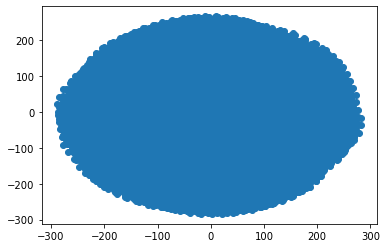

In [15]:
import matplotlib.pyplot as plt
plt.scatter(xvis.u_lambda, xvis.v_lambda)
plt.show(block=False)

Recast as Visibility using an unstack of the baseline and then a stack of the various dimensions

In [19]:
xtaaf=xvis.data.unstack("baseline").stack(taaf_index=["time", "antenna2", "antenna1", "frequency"])
print(xtaaf.uvw)
print(xtaaf.vis)

<xarray.DataArray 'uvw' (uvw_index: 3, taaf_index: 2204480)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * uvw_index   (uvw_index) <U1 'u' 'v' 'w'
  * taaf_index  (taaf_index) MultiIndex
  - time        (taaf_index) float64 5.085e+09 5.085e+09 ... 5.085e+09 5.085e+09
  - antenna2    (taaf_index) int64 0 0 0 0 0 0 0 ... 165 165 165 165 165 165 165
  - antenna1    (taaf_index) int64 0 0 0 0 0 1 1 ... 164 164 165 165 165 165 165
  - frequency   (taaf_index) float64 1e+08 1.025e+08 ... 1.075e+08 1.1e+08
Attributes:
    units:    m
<xarray.DataArray 'vis' (polarisation: 4, taaf_index: 2204480)>
array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 1.+0.j]])
Coordinates:
  * polarisation  (polarisation) <U2 'XX' 'XY' 'YX' 'YY